In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split


num_true = 1000
num_eng = 5000
test_size = 0.2

def prepare(num_true, num_eng, test_size):
    X_eng_tr, X_eng_te, y_eng_tr, y_eng_te = train_test_split(X_eng, y_eng, train_size=num_eng)
    X_true_s, _, y_true_s, _ = train_test_split(X_true, y_true, train_size=num_true)
    
    X_rus, X_test, y_rus, y_test = train_test_split(np.vstack([X_fake, X_true_s]),
                                                    np.concatenate([y_fake, y_true_s]), 
                                                    test_size=test_size)
    
    X_train = np.vstack([X_eng_tr, X_rus])
    y_train = np.concatenate([y_eng_tr, y_rus])
    return X_train, X_test, X_eng_te, y_train, y_test, y_eng_te


def sim(x, y):
    return np.sum(x * y, axis=1) / (np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1) +1e-5)

def dist(x, y):
    return np.linalg.norm(x - y, axis=1)

In [2]:
#dict_emb = 'ru'
dict_emb = 'ru-eng'

X_fake = np.nan_to_num(np.load(dict_emb + '/fake/text_w2v.npy'))
X_true = np.nan_to_num(np.load(dict_emb + '/true/text_w2v.npy'))
X_eng = np.nan_to_num(np.load(dict_emb + '/eng/text_w2v.npy'))

y_fake = np.load(dict_emb + '/fake/y.npy')
y_true = np.load(dict_emb + '/true/y.npy')
y_eng = np.load(dict_emb + '/eng/y.npy')

In [3]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')


def get_score():
    f1, acc = [np.zeros(5), np.zeros(5)], [np.zeros(5), np.zeros(5)]

    for i in range(5):
        X_train, X_test, X_eng_te, y_train, y_test, y_eng_te = prepare(num_true, num_eng, test_size)
        clf = LGBMClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_eng_pr = clf.predict(X_eng_te)
        f1[0][i], f1[1][i] = f1_score(y_test, y_pred), f1_score(y_eng_te, y_eng_pr)
        acc[0][i], acc[1][i] = accuracy_score(y_test, y_pred), accuracy_score(y_eng_te, y_eng_pr)
    
    print('ru\t f1:', np.mean(f1[0]), 'acc', np.mean(acc[0]))
    print('eng\t f1:', np.mean(f1[1]), 'acc', np.mean(acc[1]))
    
get_score()

ru	 f1: 0.848445067443107 acc 0.8539509536784742
eng	 f1: 0.8571317288010396 acc 0.8587863581451538


In [4]:
X_fake = np.nan_to_num(np.load(dict_emb + '/fake/text_d2v.npy'))
X_true = np.nan_to_num(np.load(dict_emb + '/true/text_d2v.npy'))
X_eng = np.nan_to_num(np.load(dict_emb + '/eng/text_d2v.npy'))

get_score()

ru	 f1: 0.8556309376876715 acc 0.864850136239782
eng	 f1: 0.8666541170875837 acc 0.868841185763405


In [18]:
def evaluate(clf, num_true, num_eng, test_size=0.2):
    rus_f1, rus_acc, eng_f1, eng_acc = 0, 0, 0, 0
    for i in range(5):
        X_train, X_test, X_eng_te, y_train, y_test, y_eng_te = prepare(num_true, num_eng, test_size)
    
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        eng_pred = clf.predict(X_eng_te)
        
        rus_f1 += f1_score(y_test, y_pred)
        eng_f1 += f1_score(y_eng_te, eng_pred)
        
    return rus_f1 / 5, eng_f1 / 5

res = {'rus': np.zeros([10, 20]),
       'eng': np.zeros([10, 20])}


for i, num_true in enumerate(np.arange(500, 5500, step=500)):
    for j, num_eng in enumerate(np.arange(1000, 21000, step=1000)):
        clf = LGBMClassifier()
        metrics = evaluate(clf, num_true, num_eng)
        
        res['rus'][i, j] = metrics[0]
        res['eng'][i, j] = metrics[1]

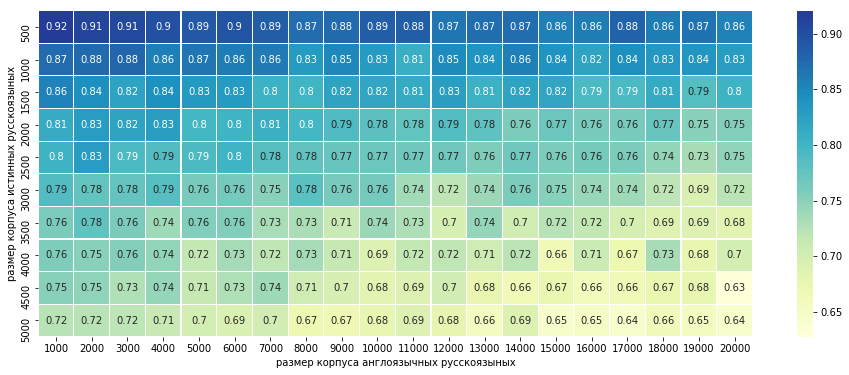

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[16, 6])
ax = sns.heatmap(pd.DataFrame(res['rus'], 
                              index=np.arange(500, 5500, step=500),
                              columns=np.arange(1000, 21000, step=1000)), 
                 linewidth=0.1, center=0.8, cmap="YlGnBu", annot=True)
plt.xlabel('размер корпуса англоязычных русскоязыных')
plt.ylabel('размер корпуса истинных русскоязыных')

plt.show()

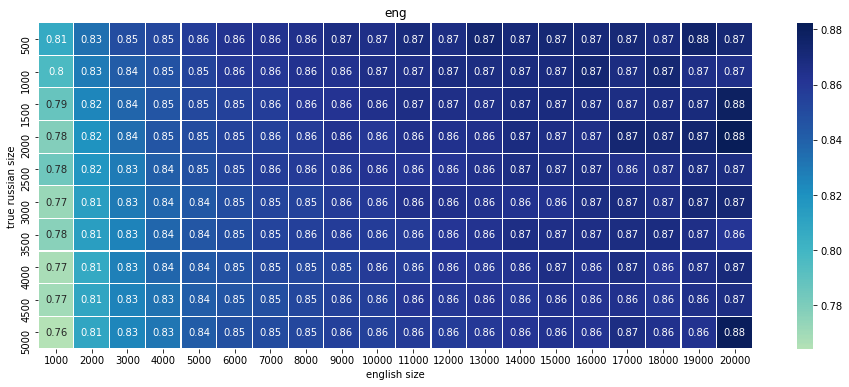

In [24]:
plt.figure(figsize=[16, 6])
ax = sns.heatmap(pd.DataFrame(res['eng'], 
                              index=np.arange(500, 5500, step=500),
                              columns=np.arange(1000, 21000, step=1000)), 
                 linewidth=0.1, center=0.8, cmap="YlGnBu", annot=True)
plt.title('eng')
plt.xlabel('english size')
plt.ylabel('true russian size')

plt.show()

In [26]:
X_fake_title = np.nan_to_num(np.load(dict_emb + '/fake/title_d2v.npy'))
X_true_title = np.nan_to_num(np.load(dict_emb + '/true/title_d2v.npy'))
X_eng_title = np.nan_to_num(np.load(dict_emb + '/eng/title_d2v.npy'))

X_fake_lda = np.load(dict_emb + '/fake/text_lda.npy')
X_true_lda = np.load(dict_emb + '/true/text_lda.npy')
X_eng_lda = np.load(dict_emb + '/eng/text_lda.npy')

sim_fake, dist_fake = sim(X_fake, X_fake_title)[:, None], dist(X_fake, X_fake_title)[:, None]
sim_true, dist_true = sim(X_true, X_true_title)[:, None], dist(X_true, X_true_title)[:, None]
sim_eng, dist_eng = sim(X_eng, X_eng_title)[:, None], dist(X_eng, X_eng_title)[:, None]

In [28]:
X_fake = np.hstack([X_fake, sim_fake, dist_fake])
X_true = np.hstack([X_true, sim_true, dist_true])
X_eng = np.hstack([X_eng, sim_eng, dist_eng])

num_true = 500
num_eng = 10000

get_score()

ru	 f1: 0.9089672471192122 acc 0.8794007490636705
eng	 f1: 0.8734931859566355 acc 0.8748443453210667


In [29]:
X_fake = np.hstack([X_fake, X_fake_lda])
X_true = np.hstack([X_true, X_true_lda])
X_eng = np.hstack([X_eng, X_eng_lda])

get_score()

ru	 f1: 0.9270761031073297 acc 0.904868913857678
eng	 f1: 0.8838558550448319 acc 0.8856240126382307
